Required libraries

In [71]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

## Import the MNIST collection of images

In [22]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()
print(
    f"Train_x = {train_x.shape}\nTrain_y = {train_y.shape}\nTest_x = {test_x.shape}\nTest_y = {test_y.shape}"
)

Train_x = (60000, 28, 28)
Train_y = (60000,)
Test_x = (10000, 28, 28)
Test_y = (10000,)


In [23]:
# More infos
print(
    f"Labels = {np.unique(train_y)}"
)
print(
    f"Train_x values = ({train_x.min()}, {train_x.max()})\nTest_x values = ({test_x.min()}, {test_x.max()})"
)

Labels = [0 1 2 3 4 5 6 7 8 9]
Train_x values = (0, 255)
Test_x values = (0, 255)


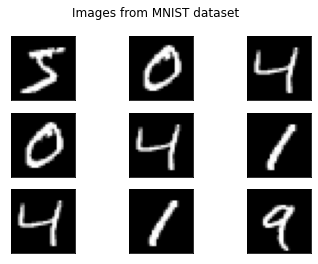

In [24]:
# Plotting the images
fig, ax = plt.subplots(3, 3)
for i in range(3):
  for j in range(3):
    ax[i][j].imshow(train_x[i + j], cmap = plt.get_cmap('gray'))
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
fig.suptitle("Images from MNIST dataset")
plt.show()

## First try with a Shallow Neural Network


*create_model* functions allows us to create different kinds of shallow neural network by passing the number of hidden nodes we want (remember that for this particular problem the network must have 10 output nodes). 

This function will be particularly useful for the hyperparameter tuning.

In [25]:
def create_model(hidden_nodes : int, activation : str):
  model = None
  try:
    model = keras.Sequential(
        [
          layers.Dense(units = hidden_nodes, activation = activation, input_shape = (784,) ,name = "hidden_layer"),
          layers.Dense(units = 10, name = "output_layer"),
          layers.Softmax()
        ]
    )
  except ValueError:
    print("Unknown activation function passed. Look on the doc for available activation functions.")
  
  return model

In [26]:
# Prepare the data
# Getting the validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, stratify = train_y, shuffle = True)
train_x, val_x = train_x.reshape((-1, 784)), val_x.reshape((-1, 784))
print(f"Train size = {train_x.shape}, Validation size = {val_x.shape}")

# Rescaling pixels
minmax = lambda x : x / 255.
train_x, val_x, test_x = minmax(train_x), minmax(val_x), minmax(test_x)

# Create keras dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.batch(64)

test_x = test_x.reshape((-1, 784))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_dataset = test_dataset.batch(64)

Train size = (48000, 784), Validation size = (12000, 784)


In [28]:
# Run the model on gpu
device_name = tf.test.gpu_device_name()

with tf.device(device_name):
  shallow = create_model(100, "sigmoid")
  # Compile the model
  shallow.compile(
      optimizer = keras.optimizers.Adam(learning_rate = 0.001),
      loss = keras.losses.SparseCategoricalCrossentropy(),
      metrics = keras.metrics.SparseCategoricalAccuracy()
  )
  # Train the model
  history = shallow.fit(
        x = train_dataset,
        epochs = 25,
        validation_data = val_dataset
  )

Epoch 1/25
750/750 [==============================] - 3s 3ms/step - loss: 0.5609 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.3109 - val_sparse_categorical_accuracy: 0.9153
Epoch 2/25
750/750 [==============================] - 2s 3ms/step - loss: 0.2647 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.2430 - val_sparse_categorical_accuracy: 0.9300
Epoch 3/25
750/750 [==============================] - 2s 3ms/step - loss: 0.2086 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.2027 - val_sparse_categorical_accuracy: 0.9421
Epoch 4/25
750/750 [==============================] - 2s 3ms/step - loss: 0.1729 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1794 - val_sparse_categorical_accuracy: 0.9486
Epoch 5/25
750/750 [==============================] - 2s 3ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.1565 - val_sparse_categorical_accuracy: 0.9547
Epoch 6/25
750/750 [==============================] - 2s 3ms/step - loss: 0.1272 - sparse_categorica

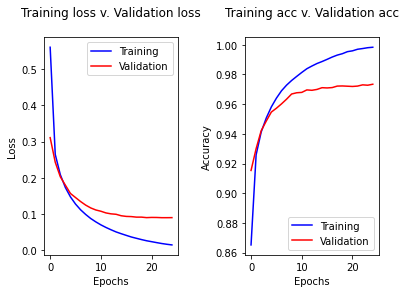

<Figure size 2000x1600 with 0 Axes>

In [76]:
# Loss plot
train_loss, val_loss = history.history["loss"], history.history["val_loss"]
train_acc, val_acc = history.history["sparse_categorical_accuracy"], history.history["val_sparse_categorical_accuracy"]
eps = list(range(25))

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.5)
figure(figsize=(10, 8), dpi=200);

# Plot 1
l1, = ax[0].plot(eps, train_loss, color = "blue", label = "Training")
l2, = ax[0].plot(eps, val_loss, color = "red", label = "Validation")
ax[0].legend(handles = [l1, l2])
ax[0].set_title("Training loss v. Validation loss\n");
ax[0].set_xlabel("Epochs");
ax[0].set_ylabel("Loss");

# Plot 2
l3, = ax[1].plot(eps, train_acc, color = "blue", label = "Training")
l4, = ax[1].plot(eps, val_acc, color = "red", label = "Validation")
ax[1].legend(handles = [l3, l4])
ax[1].set_title("Training acc v. Validation acc\n");
ax[1].set_xlabel("Epochs");
ax[1].set_ylabel("Accuracy");

In [83]:
# Evaluation on test set
with tf.device(device_name):
  result = shallow.evaluate(test_dataset, verbose = False)
  print(
      "Test set loss : {:.4f}\nTest set accuracy : {:.2f}%".format(result[0], result[1]*100)
  )

Test set loss : 0.0842
Test set accuracy : 97.52%
